<a href="https://colab.research.google.com/github/GerardNaharro/Videojuego68k/blob/main/Practica2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import random
from PIL import Image

import numpy as np

import tensorflow as tf

from tensorflow.python.keras.layers import Input, Dense

 
import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as datasets
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
#!ls "/content/drive/My Drive"
#!cd "/content/drive/My Drive/HorseHuman/Entreno/"

!ls "drive/MyDrive/HorseHuman/Entreno"
!cd "drive/MyDrive/HorseHuman/Entreno"
!unzip "drive/MyDrive/HorseHuman/Entreno/horse-or-human.zip"

horse-or-human.zip
Archive:  drive/MyDrive/HorseHuman/Entreno/horse-or-human.zip
  inflating: horses/horse01-0.png    
  inflating: horses/horse01-1.png    
  inflating: horses/horse01-2.png    
  inflating: horses/horse01-3.png    
  inflating: horses/horse01-4.png    
  inflating: horses/horse01-5.png    
  inflating: horses/horse01-6.png    
  inflating: horses/horse01-7.png    
  inflating: horses/horse01-8.png    
  inflating: horses/horse01-9.png    
  inflating: horses/horse02-0.png    
  inflating: horses/horse02-1.png    
  inflating: horses/horse02-2.png    
  inflating: horses/horse02-3.png    
  inflating: horses/horse02-4.png    
  inflating: horses/horse02-5.png    
  inflating: horses/horse02-6.png    
  inflating: horses/horse02-7.png    
  inflating: horses/horse02-8.png    
  inflating: horses/horse02-9.png    
  inflating: horses/horse03-0.png    
  inflating: horses/horse03-1.png    
  inflating: horses/horse03-2.png    
  inflating: horses/horse03-3.png    
  infla

In [4]:
horses_files = os.listdir('horses/')
horses_files = list(filter(lambda x: x != 'horses', horses_files))
horses_files = list(map(lambda p: f"horses/{p}", horses_files))

print("total horses images", len(horses_files))



humans_files = os.listdir('humans/')
humans_files = list(filter(lambda x: x != 'humans', humans_files))
humans_files = list(map(lambda p: f"humans/{p}", humans_files))

print("total humans images", len(humans_files))

img_files = horses_files + humans_files
print("total images", len(img_files))
random.shuffle(img_files)
#TODO: Aquí podeu substituir les X per nombres, d'aquesta manera podeu fer conjunts més grans o més petits.
# per entrenar més ràpid o més consistent
ttrain = img_files[:750] 
ttest = img_files[750:1027]

print("train size:", len(ttrain))
print("test size:", len(ttest))

total horses images 500
total humans images 527
total images 1027
train size: 750
test size: 277


In [1]:
# image normalization
transform = transforms.Compose([
    transforms.Resize(227),
    transforms.ToTensor()
])

# Constructor del dataset.
class HorseHumanDataset(Dataset):
    def __init__(self, image_paths, transform):
      super().__init__()
      self.paths = image_paths
      self.len = len(self.paths)
      self.transform = transform

    def __len__(self): 
      return self.len

    def __getitem__(self, index):
      path = self.paths[index]
      image = Image.open(path).convert('RGB')
      image = self.transform(image)
      label = 0 if 'humans' in path else 1
      return (image, label)


# creació dels conjunts d'entrenament i test
train_ds = HorseHumanDataset(ttrain, transform)
test_ds = HorseHumanDataset(ttest, transform)


train_dl = DataLoader(train_ds, batch_size=50)
test_dl = DataLoader(test_ds, batch_size=50)



batch = next(iter(train_ds))


# mostrar una imatge del batch
img = np.array(batch[0])
print(img.shape)
img = np.moveaxis(img, 0, -1)
plt.imshow(img)
plt.show()

NameError: ignored

TRANSFER LEARNING

In [6]:
alex = models.alexnet(weights=True)

print("-"*50)
print("Arquitectura AlexNet")
print("-"*50)
print(alex)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

--------------------------------------------------
Arquitectura AlexNet
--------------------------------------------------
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classi

In [57]:
for param in alex.features.parameters():
  param.requires_grad = False

my_net =  nn.Sequential(alex.features ,
                        nn.Flatten(1,-1),
                        alex.classifier,
                        nn.Linear(1000, 2),
                        nn.Softmax(dim=1)
                        )

ENTRENAMENT


In [51]:
def train(model, device, train_loader, optimizer, epoch, log_interval=10, verbose=True):
    
    model.train()

    loss_v = 0

    for batch_idx, (data, target) in enumerate(train_loader):
    
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)

        loss = nn.CrossEntropyLoss(reduction='sum')(output, target) 
            
        loss.backward()
        optimizer.step()
        if verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Average: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), loss.item()/ len(data)))
        loss_v += loss.item()

    loss_v /= len(train_loader.dataset)
    print('\nTrain set: Average loss: {:.4f}\n'.format(loss_v))
 
    return loss_v


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            test_loss += nn.CrossEntropyLoss(reduction='sum')(output, target) 
            
            
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max probability
            correct += pred.eq(target.view_as(pred)).sum().item()
 
  
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return test_loss

In [85]:
class BinaryAlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super(BinaryAlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [86]:
use_cuda = False
torch.manual_seed(33)

if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

epochs = 6
lr = 0.0001

model = BinaryAlexNet().to(device)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Parameters ", pytorch_total_params)
optimizer = optim.Adam(model.parameters(), lr=lr)

# Guardam el valor de pèrdua mig de cada iteració (època)
train_l = np.zeros((epochs))
test_l = np.zeros((epochs))

# Bucle d'entrenament
for epoch in range(0, epochs):
    train_l[epoch] = train(model, device, train_dl, optimizer, epoch)
    test_l[epoch]  = test(model, device, test_dl)

Parameters  57012034
Train Epoch: 0 [0/750 (0%)]	Loss: 34.683006, Average: 0.693660
Train Epoch: 0 [50/750 (7%)]	Loss: 34.650311, Average: 0.693006
Train Epoch: 0 [100/750 (13%)]	Loss: 34.523746, Average: 0.690475
Train Epoch: 0 [150/750 (20%)]	Loss: 35.025116, Average: 0.700502
Train Epoch: 0 [200/750 (27%)]	Loss: 34.988369, Average: 0.699767
Train Epoch: 0 [250/750 (33%)]	Loss: 34.545452, Average: 0.690909
Train Epoch: 0 [300/750 (40%)]	Loss: 34.596474, Average: 0.691929
Train Epoch: 0 [350/750 (47%)]	Loss: 34.512070, Average: 0.690241
Train Epoch: 0 [400/750 (53%)]	Loss: 34.636925, Average: 0.692738
Train Epoch: 0 [450/750 (60%)]	Loss: 34.497398, Average: 0.689948
Train Epoch: 0 [500/750 (67%)]	Loss: 34.693859, Average: 0.693877
Train Epoch: 0 [550/750 (73%)]	Loss: 34.637299, Average: 0.692746
Train Epoch: 0 [600/750 (80%)]	Loss: 34.501316, Average: 0.690026
Train Epoch: 0 [650/750 (87%)]	Loss: 34.537884, Average: 0.690758
Train Epoch: 0 [700/750 (93%)]	Loss: 34.467770, Average: 0.6

In [ ]:
#!rm -m horses/

In [87]:
!unzip "drive/MyDrive/HorseHuman/Test/validation-horse-or-human.zip"

Archive:  drive/MyDrive/HorseHuman/Test/validation-horse-or-human.zip
   creating: validation-horse-or-human/
   creating: validation-horse-or-human/VALhorses/
  inflating: validation-horse-or-human/VALhorses/horse1-000.png  
  inflating: validation-horse-or-human/VALhorses/horse1-105.png  
  inflating: validation-horse-or-human/VALhorses/horse1-122.png  
  inflating: validation-horse-or-human/VALhorses/horse1-127.png  
  inflating: validation-horse-or-human/VALhorses/horse1-170.png  
  inflating: validation-horse-or-human/VALhorses/horse1-204.png  
  inflating: validation-horse-or-human/VALhorses/horse1-224.png  
  inflating: validation-horse-or-human/VALhorses/horse1-241.png  
  inflating: validation-horse-or-human/VALhorses/horse1-264.png  
  inflating: validation-horse-or-human/VALhorses/horse1-276.png  
  inflating: validation-horse-or-human/VALhorses/horse1-298.png  
  inflating: validation-horse-or-human/VALhorses/horse1-335.png  
  inflating: validation-horse-or-human/VALhorses

In [91]:

horses_val_files = os.listdir('validation-horse-or-human/VALhorses/')
horses_val_files = list(filter(lambda x: x != 'validation-horse-or-human/VALhorses', horses_val_files))
horses_val_files = list(map(lambda p: f"validation-horse-or-human/VALhorses/{p}", horses_val_files))

print("total validation horses images", len(horses_val_files))



humans_val_files = os.listdir('validation-horse-or-human/VALhumans/')
humans_val_files = list(filter(lambda x: x != 'validation-horse-or-human/VALhumans', humans_val_files))
humans_val_files = list(map(lambda p: f"validation-horse-or-human/VALhumans/{p}", humans_val_files))

print("total validation humans images", len(humans_val_files))

img_val_files = horses_val_files + humans_val_files
print("total images", len(img_val_files))
random.shuffle(img_val_files)


total validation horses images 128
total validation humans images 128
total images 256


(3, 227, 227)


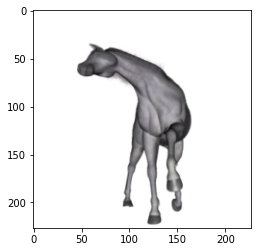


Test set: Average loss: 0.4879, Accuracy: 211/256 (82%)



tensor(0.4879)

In [93]:
val_ds = HorseHumanDataset(img_val_files, transform)
val_dl = DataLoader(val_ds, batch_size=50)

# mostrar una imatge del batch
batch = next(iter(val_ds))
img = np.array(batch[0])
print(img.shape)
img = np.moveaxis(img, 0, -1)
plt.imshow(img)
plt.show()


validacion = test(model, device, val_dl)
validacion

In [106]:

class Net(nn.Module):
    def __init__(self, num_classes=2):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2), #58
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), #29
            nn.Conv2d(64, 384, kernel_size=3, padding=1), #29
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 128, kernel_size=3, padding=1), #29
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), #13
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(128 * 13 * 13, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, num_classes),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [107]:
def train2(model, device, train_loader, optimizer, epoch, log_interval=10, verbose=True):
    
    model.train()

    loss_v = 0

    for batch_idx, (data, target) in enumerate(train_loader):
    
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)

        loss = nn.CrossEntropyLoss(reduction='sum')(output, target) 
            
        loss.backward()
        optimizer.step()
        if verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Average: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), loss.item()/ len(data)))
        loss_v += loss.item()

    loss_v /= len(train_loader.dataset)
    print('\nTrain set: Average loss: {:.4f}\n'.format(loss_v))
 
    return loss_v


def test2(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            test_loss += nn.CrossEntropyLoss(reduction='sum')(output, target) 
            
            
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max probability
            correct += pred.eq(target.view_as(pred)).sum().item()
 
  
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return test_loss

In [108]:
# creació dels conjunts d'entrenament i test
train_ds = HorseHumanDataset(ttrain, transform)
test_ds = HorseHumanDataset(ttest, transform)


train_dl = DataLoader(train_ds, batch_size=50)
test_dl = DataLoader(test_ds, batch_size=50)

use_cuda = False
torch.manual_seed(33)

if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

epochs = 6
lr = 0.0001

model = Net().to(device)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Parameters ", pytorch_total_params)
optimizer = optim.Adam(model.parameters(), lr=lr)

# Guardam el valor de pèrdua mig de cada iteració (època)
train_l = np.zeros((epochs))
test_l = np.zeros((epochs))

# Bucle d'entrenament
for epoch in range(0, epochs):
    train_l[epoch] = train2(model, device, train_dl, optimizer, epoch)
    test_l[epoch]  = test2(model, device, test_dl)

Parameters  11764482
Train Epoch: 0 [0/750 (0%)]	Loss: 34.508656, Average: 0.690173
Train Epoch: 0 [50/750 (7%)]	Loss: 34.288723, Average: 0.685774
Train Epoch: 0 [100/750 (13%)]	Loss: 33.688141, Average: 0.673763
Train Epoch: 0 [150/750 (20%)]	Loss: 36.194054, Average: 0.723881
Train Epoch: 0 [200/750 (27%)]	Loss: 35.754723, Average: 0.715094
Train Epoch: 0 [250/750 (33%)]	Loss: 33.873283, Average: 0.677466
Train Epoch: 0 [300/750 (40%)]	Loss: 33.821953, Average: 0.676439
Train Epoch: 0 [350/750 (47%)]	Loss: 34.136082, Average: 0.682722
Train Epoch: 0 [400/750 (53%)]	Loss: 33.696064, Average: 0.673921
Train Epoch: 0 [450/750 (60%)]	Loss: 33.501682, Average: 0.670034
Train Epoch: 0 [500/750 (67%)]	Loss: 33.169743, Average: 0.663395
Train Epoch: 0 [550/750 (73%)]	Loss: 32.376926, Average: 0.647539
Train Epoch: 0 [600/750 (80%)]	Loss: 32.708210, Average: 0.654164
Train Epoch: 0 [650/750 (87%)]	Loss: 32.251396, Average: 0.645028
Train Epoch: 0 [700/750 (93%)]	Loss: 31.583803, Average: 0.6

In [109]:
validacion2 = test(model, device, val_dl)
validacion2


Test set: Average loss: 0.5019, Accuracy: 208/256 (81%)



tensor(0.5019)

In [110]:
!unzip "drive/MyDrive/HorseHuman/Reales/VALReals.zip"

Archive:  drive/MyDrive/HorseHuman/Reales/VALReals.zip
   creating: VALReals/
   creating: VALReals/ValHorsesReal/
 extracting: VALReals/ValHorsesReal/horse11.png  
  inflating: VALReals/ValHorsesReal/horse12.png  
 extracting: VALReals/ValHorsesReal/horse13.png  
 extracting: VALReals/ValHorsesReal/horse14.png  
  inflating: VALReals/ValHorsesReal/horse15.png  
  inflating: VALReals/ValHorsesReal/horse16.png  
  inflating: VALReals/ValHorsesReal/horse17.png  
  inflating: VALReals/ValHorsesReal/horse18.png  
  inflating: VALReals/ValHorsesReal/horse19.png  
  inflating: VALReals/ValHorsesReal/horse20.png  
  inflating: VALReals/ValHorsesReal/horses1.png  
 extracting: VALReals/ValHorsesReal/horses10.png  
 extracting: VALReals/ValHorsesReal/horses2.png  
 extracting: VALReals/ValHorsesReal/horses3.png  
 extracting: VALReals/ValHorsesReal/horses4.png  
 extracting: VALReals/ValHorsesReal/horses5.png  
 extracting: VALReals/ValHorsesReal/horses6.png  
 extracting: VALReals/ValHorsesRea

In [112]:
horses_val_real_files = os.listdir('VALReals/ValHorsesReal/')
horses_val_real_files = list(filter(lambda x: x != 'VALReals/ValHorsesReal', horses_val_real_files))
horses_val_real_files = list(map(lambda p: f"VALReals/ValHorsesReal/{p}", horses_val_real_files))

print("total validation horses images", len(horses_val_real_files))



humans_val_real_files = os.listdir('VALReals/ValHumansReal/')
humans_val_real_files = list(filter(lambda x: x != 'VALReals/ValHumansReal', humans_val_real_files))
humans_val_real_files = list(map(lambda p: f"VALReals/ValHumansReal/{p}", humans_val_real_files))

print("total validation humans images", len(humans_val_real_files))

img_val_real_files = horses_val_real_files + humans_val_real_files
print("total images", len(img_val_real_files))
random.shuffle(img_val_real_files)

total validation horses images 20
total validation humans images 22
total images 42


(3, 227, 403)


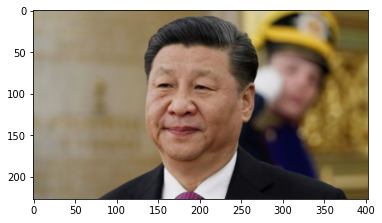

In [115]:
val_ds_real = HorseHumanDataset(img_val_real_files, transform)
val_dl_real = DataLoader(val_ds_real, batch_size=42)

# mostrar una imatge del batch
batch = next(iter(val_ds_real))
img = np.array(batch[0])
print(img.shape)
img = np.moveaxis(img, 0, -1)
plt.imshow(img)
plt.show()


In [116]:
validacion3 = test(model, device, val_dl_real)
validacion3

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


RuntimeError: ignored